<Axes: xlabel='Date'>

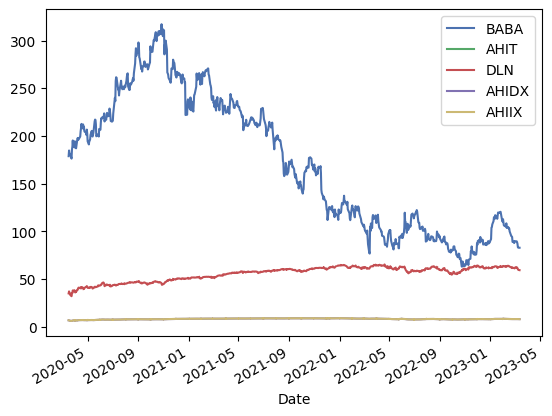

In [48]:
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import numpy as np
import pandas as pd
import copy

stocks = pd.read_pickle("../Datas/test.pkl")
cols = stocks.columns.tolist()
for col in cols:
    stocks[col] = pd.to_numeric(stocks[col])

stocks.plot()

### Mean-Variance Optimal Portfolio
- Need Expected returns for each stocks
- Need the covariance matrix of all stocks returns
- Minimizing the portfolio varianc
- Efficient frontier -> point that maximize the Sharpe ratio


### Returns / Mean_historical_Expected_returns

BABA    -0.189914
AHIT     0.000000
DLN      0.155418
AHIDX    0.046210
AHIIX    0.044960
dtype: float64

<Axes: xlabel='Date'>

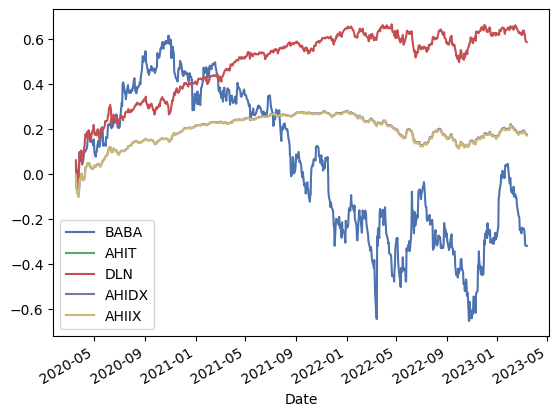

In [49]:
stocks_returns = stocks.pct_change()[1:]
stocks_returns.head()
exp_ret = expected_returns.mean_historical_return(stocks)
display(exp_ret)
stocks.pct_change()[1:].cumsum().plot()

### Variance / Covariance Matrix

,BABA,AHIT,DLN,AHIDX,AHIIX
BABA,0.254017,NaN,0.023552,0.009092,0.009226
AHIT,NaN,NaN,NaN,NaN,NaN
DLN,0.023552,NaN,0.031429,0.006835,0.006908
AHIDX,0.009092,NaN,0.006835,0.005175,0.005056
AHIIX,0.009226,NaN,0.006908,0.005056,0.005088


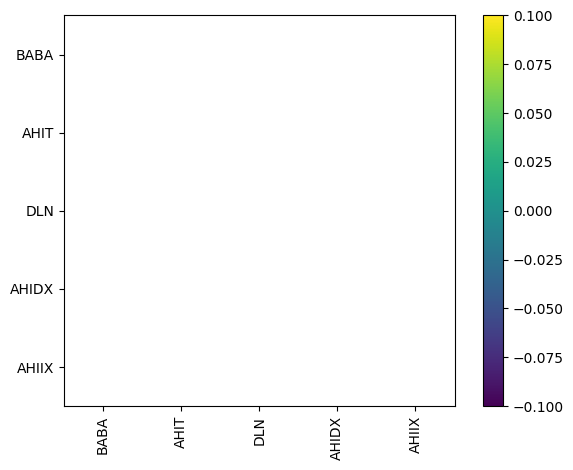

In [50]:
# variance / covariance matrix
cov_matrix2 = risk_models.sample_cov(stocks)
display(cov_matrix2)
plotting.plot_covariance(cov_matrix2, plot_correlation=True);


### Efficient Frontier for maximizing sharpe ratio

In [46]:
from pypfopt import objective_functions

ef = EfficientFrontier(exp_ret, cov_matrix2)
# optimizing to have less negligible weights 
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
print(ef.clean_weights())


OrderedDict([('HERVX', 0.15141), ('AHKSY', 0.0), ('AHHYX', 0.07338), ('AHLAX', 0.18493), ('DLN', 0.59028)])


c:\Users\feldm\Documents\GitHub\portfolio_forecasting\ten\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


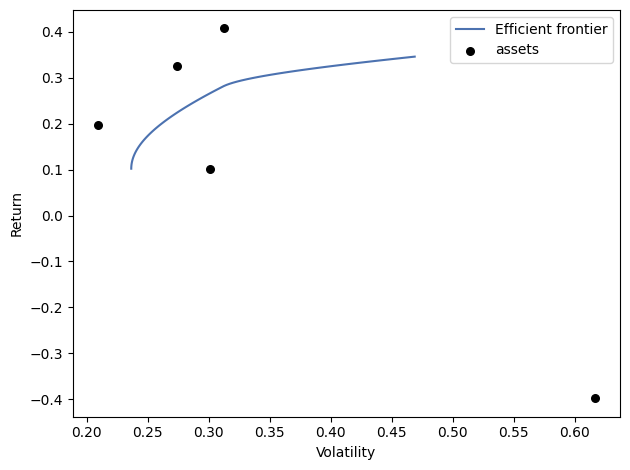

In [42]:
ef = EfficientFrontier(exp_ret, cov_matrix2, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [47]:
ef.portfolio_performance(verbose=True)


Expected annual return: 12.8%
Annual volatility: 13.2%
Sharpe Ratio: 0.81


(0.12758422204097866, 0.13217814860211405, 0.8139334918726344)